## Traing and inference
  - IV: prediction
  - V: plotting
  - VI: Generate the probability density and entropy data by various augmentation factors
  
  


## I. Data processing

In [6]:
##########  0. phq dataset #######################
import numpy as np
import pandas as pd
import random
import os

dir_data = '../data/'

phq = pd.read_csv(dir_data+ 'phq9_score.csv')
# phq = phq.loc[phq['type']=='post']

phq_temp=(phq.loc[:,['uid','type','depression severity','phq score','dp_grade']]).set_index('uid')
phq_temp.rename_axis('user', inplace=True)

# add phq_class column with phq_score
dp_dict={0:0,1:0,2:1,3:1}  # grade to class
dp_class = []
for i in range(phq_temp.shape[0]): 
#     print(i)
    dp_class.append(dp_dict[phq_temp["dp_grade"][i]])
phq_temp['dp_class']=dp_class  # add the class list to phq_temp dataset
phq_temp

phq_pre=phq_temp.loc[phq_temp['type']=='pre']
phq_post=phq_temp.loc[phq_temp['type']=='post']
phq_score= phq_post.merge(phq_pre, how='outer', left_index=True, right_index=True) # only select users whose the post-class is the same as the pre-class
print('Merged PHQ9 shape:',phq_score.shape)
phq_score

phq_selected= phq_score.where(phq_score['dp_class_x']==phq_score['dp_class_y'])
phq_selected.dropna(inplace=True)
print("Shape of the phq9 data with selected user is:", phq_selected.shape)
phq_selected

Merged PHQ9 shape: (46, 10)
Shape of the phq9 data with selected user is: (34, 10)


,type_x,depression severity_x,phq score_x,dp_grade_x,dp_class_x,type_y,depression severity_y,phq score_y,dp_grade_y,dp_class_y
user,,,,,,,,,,
u00,post,minimal,3.0,0.0,0.0,pre,minimal,2.0,0.0,0.0
u01,post,minimal,4.0,0.0,0.0,pre,mild,5.0,1.0,0.0
u03,post,minimal,4.0,0.0,0.0,pre,minimal,2.0,0.0,0.0
u04,post,mild,8.0,1.0,0.0,pre,mild,6.0,1.0,0.0
u05,post,minimal,0.0,0.0,0.0,pre,minimal,2.0,0.0,0.0
u07,post,mild,8.0,1.0,0.0,pre,mild,7.0,1.0,0.0
u09,post,minimal,2.0,0.0,0.0,pre,minimal,4.0,0.0,0.0
u10,post,minimal,4.0,0.0,0.0,pre,minimal,0.0,0.0,0.0
u14,post,minimal,3.0,0.0,0.0,pre,minimal,1.0,0.0,0.0


In [7]:
# '''
# DO NOT RUN THIS BLOCK !!

# Another option is to use all user holds post evaluation, no matter if pre-class is the same as the post-claee
# as blow code
# '''

# ##########  0. import phq/label and ema/sensing data #######################
# ## select user with 'post' score available 

# phq = pd.read_csv(dir_data+ 'phq9_score.csv')  # shape of 84,15
# phq = phq.loc[phq['type']=='post']
# phq=(phq.loc[:,['uid','type','depression severity','phq score','dp_grade', 'dp_class']]).set_index('uid')
# phq.rename_axis('user', inplace=True)  # change index from 'uid' to 'user'

# print("PHQ-9 shape, with selected user (post): ", phq.shape)

# ## import EMA/sensing data
# dataset = pd.read_csv(dir_data+'studentlife_data_full.csv', index_col=0)#set the col0 as index, index as "u00_2013-03-24"

# print ('Dataset shape :',dataset.shape)
# # dataset

In [8]:
#################  1 merge sensing and ema  ####################
######### ema_all.csv, sensing_all.csv  ###################
dataset_ema = pd.read_csv(dir_data+ 'ema_all.csv', index_col=0)  
print ('1. Dataset_ema shape: ',dataset_ema.shape)

dataset_sensing = pd.read_csv(dir_data+ 'sensing_all.csv', index_col=0)  
print ('2. Dataset_sensing shape: ',dataset_sensing.shape)

######### clean data ###########
dataset= dataset_sensing.merge(dataset_ema, how='outer', left_index=True, right_index=True )
print('3. Merge success ! shape of merged dataset is', dataset.shape )

def drop_notnum(dataset):
    cols=dataset.columns
    col_notnum=[]
    for col in cols:
        if str(dataset[col].dtype)=='object':
               col_notnum.append(col)
    dataset=dataset.drop(col_notnum, axis=1)
    return dataset

dataset=drop_notnum(dataset)  #abc=dataset.dropna(axis=1, how='all') # drops columns those with all NaN
dataset_ema= drop_notnum(dataset_ema)
dataset_sensing = drop_notnum(dataset_sensing)

# drop of feature contains all null values
null_feature = ['Class_null',
 'Stress_null',
 'Mood 2_null',
 'Behavior_null',
 'Study Spaces_null',
 'Sleep_null',
 'Activity_null',
 'Social_null',
 'Green Key 2_excited']
dataset = dataset.drop(null_feature, axis =1)

print('')
print('a. Removed columns of non-data, EMA dataset shape: ', dataset_ema.shape)
print('b. Removed columns of non-data, sensing dataset shape: ', dataset_sensing.shape)
print('c. Removed columns of non-data, merged dataset shape: ', dataset.shape)

# dataset.to_csv(os.path.join(dir_data+"studentlife_datafull.csv"))
print('Full dataset saved in:', dir_data)


1. Dataset_ema shape:  (3025, 107)
2. Dataset_sensing shape:  (3075, 12)
3. Merge success ! shape of merged dataset is (3407, 119)

a. Removed columns of non-data, EMA dataset shape:  (3025, 81)
b. Removed columns of non-data, sensing dataset shape:  (3075, 6)
c. Removed columns of non-data, merged dataset shape:  (3407, 78)
Full dataset saved in: ../data/


## II. Build model and functions

In [9]:
################## 2. build base model and function ##########################
from abc import ABC, abstractmethod
from keras.models import Sequential
# from keras import backend as K
# from keras import Input
# from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Embedding, Dense, Dropout, BatchNormalization,LeakyReLU, MaxPooling2D, Conv2D,Flatten
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,  accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib import dates as mdates


class BaseModel(ABC):
    """ Super class for Machine Learning Class"""
    
    @abstractmethod
    def train_predict(self):
        pass
    
    @abstractmethod
    def predict(self):
        pass
        
    def load_predict(self, X, predict_type):
        pass
    
    def accuracy(self, predict, label):
        predict = predict.ravel()
        label = label.ravel()
        return np.sum(predict == label)/len(label) 

def accuracy(predict, label):
    predict = predict.ravel()
    label = label.ravel()
    return np.sum(predict == label)/len(label) 

# def dataExtract(data, win_width =10, stride =1, forward_step= 0, label = 'label', normalize = False): # output 3 dimensions array
#     sample_num = data.shape[0]

#     y=data.loc[:,label].values
#     X = data.drop(columns = [label]) # drop 'label column, use remain for feature
#     feature_num = X.shape[1]
#     if normalize == True:
#         X = minmaxNormalize(X)
# #         X = Normalize(X)
#     X_new = np.array([[]]*feature_num).T.reshape(0,win_width,feature_num) # 3D empty array
#     y_new = []
#     for i in range(sample_num-forward_step,0, -stride):
#         X_win = X.values[i-win_width:i,:] 
#         if X_win.shape[0] <win_width:
#             break 
#         X_win = X_win.reshape(1,win_width,feature_num) # reshape to 3D for catanecating
#         X_new = np.vstack((X_new,X_win)) 
#         y_new.append(y[i+forward_step-1]) 
#     X_new = X_new[::-1,:,:] 
#     y_new = np.array(y_new[::-1]) 
#     return X_new, y_new # retrun array instead of dataframe

def minmaxNormalize(X, axis = 0): # default axis set to 0
    minum = np.min(X, axis = axis)
    maxum = np.max(X, axis = axis)
    return (X-minum)/(maxum-minum)

def Normalize(X):
    return  X/np.linalg.norm(X, ord = 2, axis = 0)

def PCA(X, k, axis=1):  # feature in rows axis =0, in cols axis =1, X in np.array formate
    if axis==0:  #features by rows
        n = X.shape[0]
        mean = np.mean(X, axis = 0).reshape(1,-1) # features number X data number 
        Xm = (X- mean)
        COV =  Xm @ Xm.T/(n-1)
        eig_value, eig_vector = np.linalg.eig(COV) 
        index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
        P = eig_vector[:,index[0:k]]
        return P.T @ Xm
    else:  #axis == 1, features by cols
#         X=dataframe.values
        n = np.array(X).shape[1]
        mean = np.mean(X, axis = 1).reshape(-1,1) # features number X data number 
        Xm = (X- mean)
        COV =  Xm.T@Xm/(n-1)
        eig_value, eig_vector = np.linalg.eig(COV) 
        index = np.argsort(-1*eig_value) # rank from the largest value to the smallest one， descend
        P = eig_vector[:,index[0:k]]
        return Xm@P
    

def slice_sum_by_id(data,id_list, win_width, stride, forward_step, label):
    x_f=np.array([])
    y_f=np.array([])
#     id_list =np.unique(data['ID'])
    for id in id_list:
        #data_id= (data.where(data['ID']==id)).dropna()
        data_id= data[data.index==id]
        x_sliced, y_sliced = dataExtract(data_id, win_width =win_width, stride =stride, \
                                         forward_step= forward_step, label = label, normalize = False)
        if not x_f.any():  # initialize 3d array
            x_f=np.empty(shape=x_sliced.shape)  #sliced size for each id =90-(win_width+stride+forward_step)+2
            y_f=np.empty(shape=y_sliced.shape)
            init=x_sliced.shape[0]
        x_f= np.append(x_f,x_sliced, axis=0)
        y_f= np.append(y_f,y_sliced, axis=0)
    x_f=x_f[init:,:,:]  # take off the first chunk created by np.empty : size of init
    y_f=y_f[init:,]
    return x_f, y_f

''' create a diction of score:grade '''
dp_grade ={0:[0,4], 1:[5,9],2:[10,14],3:[15,19],4:[20,27]} 
dp_score2grade={}
for key, value in dp_grade.items(): 
    for i in range(value[0], value[1]+1):
        dp_score2grade[i]=key
        
# normalize dataset and fill nan with -1
def minmax_normalize(df): # this min_max norm can apply dataset with NULL value
    for col in df.columns:
        df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min())
#     df.dropna(how='any', inplace=True, axis=1) # drop columns with null falue
    return df

def normalize_list(la): # normalize a 1 dimension list
    if sum(la)==0:
        lb =la # doesn't consider all la element =0
    else:
        lb=[]
        [lb.append(v/sum(la)) for v in la]  
    return lb

def entropy(lst):
    result= 0;
    lst = normalize_list(lst)
    for p in lst:
        if p == 0:
            pass
        else:
            result+=(-p)*np.log2(p)
    return result

def classifier_slice2uid(df_predicted, trigger=0.1): # 2nd round classification by user catogory in trigger method, binary
    users= np.unique(df_predicted.index)
    score_user ={}
    class_user ={}
    for user in users:
        class_slice = df_predicted.loc[user][0].to_list()
        score= sum(class_slice)/len(class_slice)
        score_user[user]=score
    for user, score in score_user.items():
        class_user[user]= int(score-trigger+1) # convert the value >threshold to be 1 
    predictions_user = pd.DataFrame(class_user.values(), index = class_user.keys()) # transfer diction to dataframe
    return predictions_user , score_user


## III. data cleaning and train/test data processing



In [10]:
''' 0. pick up features
'''


# 0. all features
col_slct= dataset.columns # ALL features, 78 cols after manully filter "null" and "green" columns

# # 1. EMA 6 + sensing 4
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate',
            'dark_duration(sec)','audio_ audio inference',
            'phonecharge_duration(sec)','activity_ activity inference'] 

# # 2. EMA  6 features
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate']

# # # # 3. sensing 4 features
col_slct=['dark_duration(sec)','audio_ audio inference',
          'phonecharge_duration(sec)','activity_ activity inference'] 


In [11]:
'''1. Data cleaning:
    - select columns
    - normalization, or
    - PCA (on demand)
'''
## normalization
dataset_col = dataset[col_slct].copy()
data_norm= minmax_normalize(dataset_col)


## process PCA ############
# dataset_np = data_norm.iloc[:,1:].to_numpy()  # transfer to numpy without index of 'user_date'
# K=2
# dataset_np=PCA(dataset_np, K, axis= 1)
# dataset_np.shape
# dataset_pca=pd.DataFrame(dataset_np, columns= np.arange(K), index= data_norm.index)


In [12]:
''' 2. Data cleaning:
    - index: user_date to user
    - add lables
    - clean data
    '''
########### 1.2 add label(dp_class) by merging phq ###############
########## add uer and set as index for merging phq ###########


# dataset_1=dataset   # no pca, no normalization
# dataset_1= dataset_pca # with both normalization + pca
dataset_1 = data_norm # with normalization , no pca

dataset_1['user']=dataset_1.index  # copy 'user' column with index values
def str_slice(str):
    return str[:3]
dataset_1['user']=dataset_1['user'].apply(str_slice)
dataset_1 = dataset_1.reset_index().set_index('user') 
dataset_1 = dataset_1.drop(['user_date'], axis=1)# keep the index columns and set 'user' col as index
dataset_1.fillna(0, inplace= True)  # impute 0 into missing data
print("Dataset before labeling is:", dataset_1.shape)

## add label of dp_class
dp_class_list=[]
for user in dataset_1.index: 
    if user in phq_selected.index.to_list():
        dp_class_list.append(phq_selected.loc[user]['dp_class_y'])
    else:
        dp_class_list.append(None) # for removing those users are not in the selected list
dataset_1['dp_class']=dp_class_list

dataset_1= dataset_1.dropna(axis = 0, how='any') # drop off instance without lable (non-selected user)  

dataset_1.to_csv(dir_data+"studentlife_datafull_with_lable.csv")

# dataset_2 = minmax_normalize(dataset_1)
print("After labeling and removing non-completed label, dataset shape is:", dataset_1.shape)


Dataset before labeling is: (3407, 4)
After labeling and removing non-completed label, dataset shape is: (2405, 5)


In [13]:
''' 3. Traing and testing dataset processing:
    - Split training and testing dataset
    - Data augment : pick the id with depression ,which stays in train dataset for augmenting'''

################## process training and testing data #######################

random_seed= 0 # 1 depression :42, 0 ,3 ; 0 depression: 2,5, 6
trigger =0.2 # threshold for 2nd round classification


agm_factor = 4 # for testing add 4 times depressed user data, randomly


def generate_train_test(dataset, agm_factor=agm_factor, random_seed = random_seed):
    random.seed(random_seed)
    split_rate =0.8
    

    id_depression_all=list(np.unique(dataset.where(dataset_1['dp_class'] == 1).dropna().index)) # users who has depression
    id_depression_test=[]    
      #### for test with data version 1
#     id_depression_all=['u17', 'u18','u23','u33','u52'] # users who have depression
#     ####
    
    id_list =list(np.unique(dataset.index))
    split = int(split_rate*len(id_list))
    id_train= sorted(random.sample(id_list,split))
    id_test= sorted(list(set(id_list)- set(id_train)))
    id_depression_train=[]

    for id in id_depression_all:
        if (id in id_train):
            id_depression_train.append(id)

#     ### another way to split by make sure at least there is a depressed user in test data
#     # id depression    
#     id_depression_test = random.sample(id_depression_all,1)
#     id_depression_train = list(set(id_depression_all)- set(id_depression_test))

#     # id nonedepression
#     split = round(split_rate*len(id_nonedepression_all))
#     id_nonedepression_train= random.sample(id_nonedepression_all, split)
#     id_nonedepression_test = list(set(id_nonedepression_all)-set(id_nonedepression_train))

#     id_test = sorted(id_depression_test + id_nonedepression_test)
#     id_train = sorted(id_depression_train + id_nonedepression_train)

    id_augment = []
    for i in range(agm_factor): # add X users with depression     
        id_augment.append(random.sample(id_depression_train,1)[0])
    id_agm =id_train+id_augment
    random.shuffle(id_agm)


    X_train= dataset.loc[id_agm,:].iloc[:,:-1] # X_train shape[0] will increase after augmenting
    y_train= dataset.loc[id_agm,:].iloc[:,-1]

    X_test= dataset.loc[id_test,:].iloc[:,:-1]
    y_test= dataset.loc[id_test,:].iloc[:,-1]

    y_train_dummy = pd.get_dummies(y_train).values
    y_test_dummy = pd.get_dummies(y_test).values
    
#     print('Testing for augmentation factor:', agm_factor)
#     print('Users in test data: ',id_test)
#     print('Users in agmentated training data: ', id_agm)
    
    return X_train, y_train, X_test , y_test, y_train_dummy, y_test_dummy, id_train, id_test

## split train/test  and dummy y
X_train, y_train, X_test , y_test, y_train_dummy, y_test_dummy, id_train, id_test  = generate_train_test(dataset_1, agm_factor=agm_factor, random_seed = random_seed)
print("Shape of X train, y_train, X test, y test : ",X_train.shape,  y_train.shape, X_test.shape, y_test.shape )
print("size of feature selected:", len(col_slct))

Shape of X train, y_train, X test, y test :  (2146, 4) (2146,) (541, 4) (541,)
size of feature selected: 4


## Prediction stage-1
    - store the result to file: dir_data+"likelihood.csv"

In [14]:
'''
A. train and predict by Machine Learning algorithms

'''
from sklearn.ensemble import RandomForestClassifier #1
from sklearn.linear_model import LogisticRegression #2
from sklearn import tree #3
from sklearn.ensemble import  GradientBoostingClassifier #4
from sklearn.ensemble import  AdaBoostClassifier #5
from sklearn.naive_bayes import GaussianNB # 6
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 7
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # 8
from sklearn.svm import SVC #9
from sklearn.neighbors import KNeighborsClassifier # 10

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False


test_class = pd.DataFrame(id_test, columns=['uid']).merge(phq, on=['uid'], how ='inner')
y_test_uid= test_class[['uid','dp_class']].drop_duplicates()['dp_class'].tolist()  #[0, 0, 0, 1, 0, 0, 0]  for ['u00', 'u07', 'u10', 'u17', 'u34', 'u35', 'u47']

# ===========================machine learning algorithms to predict and plot====================#
def ml_predict_score_user(X_train, y_train, X_test, y_test_uid):  

    ### 1. Random Foreest
    
#     print("=============================================================================================")      
#     print("1. RF")

    RF = RandomForestClassifier(n_estimators=10,random_state=11)
    RF.fit(X_train,y_train)
    predictions_1 = RF.predict(X_test)

    predicted_df = pd.DataFrame(predictions_1, index =X_test.index) 
    predictions_temp, likelihood_1  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_1 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_1 = np.sum((y_test-list(likelihood_1.values()))**2/len(y_test))

#     print(likelihood_1)
#     print("mse of score by users: ",mse_1)
#     print(classification_report(y_test,predictions_1))
#     print("AC",accuracy_score(y_test,predictions_1))



#     ####################### Plot ############################
#     fpr_1, tpr_1, thresholds_1 = \
#     roc_curve(y_test,predictions_1)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_1,tpr_1,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_1)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ###2. Logistic Regression Classifier 
    
#     print("=============================================================================================")      
#     print("2. LR")

    clf = LogisticRegression(penalty='l2')
    clf.fit(X_train,y_train)
    predictions_2 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_2, index =X_test.index) 
    predictions_temp, likelihood_2  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_2 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_2 = np.sum((y_test-list(likelihood_2.values()))**2/len(y_test))

#     print(likelihood_2)
#     print("mse of score by users: ",mse_2)
#     print(classification_report(y_test,predictions_2))
#     print("AC",accuracy_score(y_test,predictions_2))

#     ####################### Plot ############################
#     fpr_2, tpr_2, thresholds_2 = \
#     roc_curve(y_test,predictions_2)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_2,tpr_2,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_2)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ### 3. Decision Tree Classifier    
#     print("=============================================================================================")    
#     print("3. Decision Tree")

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train)
    predictions_3 = clf.predict(X_test)


    predicted_df = pd.DataFrame(predictions_3, index =X_test.index) 
    predictions_temp, likelihood_3  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_3 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_3 = np.sum((y_test-list(likelihood_3.values()))**2/len(y_test))

#     print(likelihood_3)
#     print("mse of score by users: ",mse_3)
#     print(classification_report(y_test,predictions_3))
#     print("AC",accuracy_score(y_test,predictions_3))

#     ####################### Plot ############################
#     fpr_3, tpr_3, thresholds_3 = \
#     roc_curve(y_test,predictions_3)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_3,tpr_3,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_3)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()


    ###4. Gradient Boosting Decision Tree
#     print("=============================================================================================")
#     print("4. Gradient Boosting Decision Tree")    
    clf = GradientBoostingClassifier()
    clf.fit(X_train,y_train)
    predictions_4 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_4, index =X_test.index) 
    predictions_temp, likelihood_4  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_4 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_4 = np.sum((y_test-list(likelihood_4.values()))**2/len(y_test))

#     print(likelihood_4)
#     print("mse of score by users: ",mse_4)
#     print(classification_report(y_test,predictions_4))
#     print("AC",accuracy_score(y_test,predictions_4))

#     ####################### Plot ############################
#     fpr_4, tpr_4, thresholds_4 = \
#     roc_curve(y_test,predictions_4)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_4,tpr_4,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_4)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ###5. AdaBoost Classifier
#     print("=============================================================================================")     
#     print("5. AdaBoost")

    clf = AdaBoostClassifier()
    clf.fit(X_train,y_train)
    predictions_5 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_5, index =X_test.index) 
    predictions_temp, likelihood_5  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_5 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_5 = np.sum((y_test-list(likelihood_5.values()))**2/len(y_test))

#     print(likelihood_5)
#     print("mse of score by users: ",mse_5)
#     print(classification_report(y_test,predictions_5))
#     print("AC",accuracy_score(y_test,predictions_5))

#     ####################### Plot ############################
#     fpr_5, tpr_5, thresholds_5 = \
#     roc_curve(y_test,predictions_5)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_5,tpr_5,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_5)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ### 6. GaussianNB
#     print("=============================================================================================")     
#     print("6. GaussianNB")

    clf = GaussianNB()
    clf.fit(X_train,y_train)
    predictions_6 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_6, index =X_test.index) 
    predictions_temp, likelihood_6  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_6 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_6 = np.sum((y_test-list(likelihood_6.values()))**2/len(y_test))

#     print(likelihood_6)
#     print("mse of score by users: ",mse_6)
#     print(classification_report(y_test,predictions_6))
#     print("AC",accuracy_score(y_test,predictions_6))

#     ####################### Plot ############################
#     fpr_6, tpr_6, thresholds_6 = \
#     roc_curve(y_test,predictions_6)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_6,tpr_6,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_6)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ### 7. Linear Discriminant Analysis
#     print("=============================================================================================")  
#     print("7. Linear Discriminant Analysis")

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train,y_train)
    predictions_7 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_7, index =X_test.index) 
    predictions_temp, likelihood_7  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_7 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_7 = np.sum((y_test-list(likelihood_7.values()))**2/len(y_test))

#     print(likelihood_7)
#     print("mse of score by users: ",mse_7)
#     print(classification_report(y_test,predictions_7))
#     print("AC",accuracy_score(y_test,predictions_7))

#     ####################### Plot ############################
#     fpr_7, tpr_7, thresholds = \
#     roc_curve(y_test,predictions_7)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_7,tpr_7,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_7)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ### 8. Quadratic Discriminant Analysis
#     print("=============================================================================================")   
#     print("8. Quadratic Discriminant Analysis")

    clf = QuadraticDiscriminantAnalysis(tol=1e-4)
    clf.fit(X_train,y_train)
    predictions_8 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_8, index =X_test.index) 
    predictions_temp, likelihood_8  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_8 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_8 = np.sum((y_test-list(likelihood_8.values()))**2/len(y_test))

#     print(likelihood_8)
#     print("mse of score by users: ",mse_8)
#     print(classification_report(y_test,predictions_8))
#     print("AC",accuracy_score(y_test,predictions_8))

#     ####################### Plot ############################
#     fpr_8, tpr_8, thresholds = \
#     roc_curve(y_test,predictions_8)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_8,tpr_8,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_8)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    ### 9. SVM Classifier 
#     print("=============================================================================================") 
#     print("9. SVM")
    
    clf = SVC(kernel='rbf', probability=True)
    clf.fit(X_train,y_train)
    predictions_9 = clf.predict(X_test)

    predicted_df = pd.DataFrame(predictions_9, index =X_test.index) 
    predictions_temp, likelihood_9  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_9 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_9 = np.sum((y_test-list(likelihood_9.values()))**2/len(y_test))

#     print(likelihood_9)
#     print("mse of score by users: ",mse_9)
#     print(classification_report(y_test,predictions_9))
#     print("AC",accuracy_score(y_test,predictions_9))

#     ####################### Plot ############################
#     fpr_9, tpr_9, thresholds_9 = \
#     roc_curve(y_test,predictions_9)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_9,tpr_9,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_9)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()


    ### 10. knn Classifier 
#     print("=============================================================================================") 
#     print("10. KNN")

    knn=KNeighborsClassifier(n_neighbors=5)
    knn = KNeighborsClassifier()
    knn.fit(X_train,y_train)
    predictions_10 = knn.predict(X_test)

    predicted_df = pd.DataFrame(predictions_10, index =X_test.index) 
    predictions_temp, likelihood_10  = classifier_slice2uid(predicted_df, trigger= trigger) 
    predictions_10 =  predictions_temp.iloc[:,-1].to_list() 
    y_test = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list()) 
    mse_10 = np.sum((y_test-list(likelihood_10.values()))**2/len(y_test))

#     print(likelihood_10)
#     print("mse of score by users: ",mse_10)
#     print(classification_report(y_test,predictions_10))
#     print("AC",accuracy_score(y_test,predictions_10))

#     ####################### Plot ############################
#     fpr_10, tpr_10, thresholds_10 = \
#     roc_curve(y_test,predictions_10)
#     plt.figure(figsize=(10,4))

#     plt.subplot(121)
#     # plt.xlim(0,1) 
#     # plt.ylim(0.0,1.1) 
#     plt.title('ROC',fontsize=14,fontweight='bold')
#     plt.xlabel('False Postive Rate')
#     plt.ylabel('True Postive Rate')
#     plt.plot(fpr_10,tpr_10,linewidth=2, linestyle="-",color='red')

#     plt.subplot(122)
#     ticks=['Normal','Depression']
#     conf_mat = confusion_matrix(y_test, predictions_10)
#     sns.heatmap(conf_mat, annot=True, fmt='d',
#                 xticklabels=ticks, yticklabels=ticks,cmap="Blues")
#     plt.title('Confusion Matrix',fontsize=14,fontweight='bold')
#     plt.ylabel('Actual',fontsize=12)
#     plt.xlabel('Prediction',fontsize=12)
#     plt.show()

    
    return likelihood_1,likelihood_2,likelihood_3,likelihood_4,likelihood_5, likelihood_6, likelihood_7, likelihood_8,likelihood_9, likelihood_10,\
    mse_1,mse_2,mse_3,mse_4,mse_5,mse_6,mse_7,mse_8,mse_9,mse_10



In [15]:
# ###############  start iteration by augmentation factor ###################
# #######################################################################
import time
seed_value =0 
split_rate =0.8

## start train and predict
p_ml =  pd.DataFrame()
# nondepression_idnum_train=len(np.unique(y_train.index))-len(id_dptrain) # none depression id number in training
nondepression_idnum_train=len(np.unique(y_train.index))

algorithm_list = ["BLANK","RF","LR","DT","GBDT","AB","GNB","LDA","QDA","SVM","KNN"]

for j in range(6):   # j stands for the augmenting factor 
    X_train, y_train, X_test, y_test, y_train_dummy, y_test_dummy, id_train, id_test \
    = generate_train_test(dataset_1, agm_factor=j, random_seed = seed_value) # generate train dataset
    
    score_user_1,score_user_2,score_user_3,score_user_4,score_user_5, score_user_6, score_user_7, score_user_8,\
    score_user_9,score_user_10, mse_1,mse_2,mse_3,mse_4,mse_5,mse_6,mse_7,mse_8,mse_9,mse_10 \
    = ml_predict_score_user(X_train, y_train, X_test, y_test_uid) # train and predict with ML ================
    

    for i in range(1,len(algorithm_list)): # total 10 algorithms, starts from 1
#         print('score_user_{}='.format(i))
#         var=eval("score_user_"+str(i))
#         print(var)
        p_temp=[] 
        p_temp.append(int(time.time()))
        p_temp.append(j)
        p_temp.extend(list(eval("score_user_"+str(i)).values()))  # predicted
        p_temp.extend(y_test_uid)  # ground truth in user granilarity
        p_temp.append(eval("mse_"+str(i)))
        p_temp.append(entropy(list(eval("score_user_"+str(i)).values()))) # entropy under prediction with algorithm i
        p_temp.append(algorithm_list[i])
        p_temp.append(len(col_slct))
        p_temp.append(seed_value)
        p_series =  pd.Series(p_temp)
        p_ml = p_ml.append(p_series, ignore_index=True)

user_prob_col, user_gth_col, user_prd_col, =[], [], []
[(user_prob_col.append(u+'_prob'), user_gth_col.append(u+'gth'), user_prd_col.append(u+'_prd')) for u in score_user_1.keys()] # e.g. [u01_prd, ...]

p_col = ["time","aug_factor"]+user_prob_col + user_gth_col +["mse","entropy","model","feature num","random seed"]
p_ml.columns= p_col
p_ml['feature num']=p_ml['feature num'].astype(int) #format the feature type
p_ml['aug_factor']=p_ml['aug_factor'].astype(int)
p_ml.to_csv(dir_data+"likelihood.csv", mode="a", index= False)
print("Stage1 prediction result saved in:", dir_data)

Stage1 prediction result saved in: ../data/


In [ ]:
''' 
B.train and predict by DNN 

###################### ONLY for DNN experiment to find aug factor: ##############################
##############  output: array of factor+ predicted probability list by user_test+ trueth list + mse  ############
############### this section follows the function defination sections(before data process section)  ###############

'''

import time
###############  Training ,prediction #################################
def dnn_predict_score_user(X_train, y_train_dummy, epochs):
    epochs = epochs

    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')) # input_dim = numb of features, 1D number
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))  # 5 classes
#     model.summary()
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
    history=model.fit(X_train, y_train_dummy, epochs=epochs,validation_split=0.33, batch_size=32, verbose = 0)

    y_predict = model.predict(X_test)
    y_predicted = y_predict.argmax(axis = 1)
    y_t = y_test_dummy.argmax(axis =1)

    predicted_df = pd.DataFrame(y_predicted, index =X_test.index) # dataframe of predected label + user index
    predictions_temp, score_user  = classifier_slice2uid(predicted_df, trigger= trigger) # predictions output in df formate , by user id
    predictions =  predictions_temp.iloc[:,-1].to_list()  # convert to array 
    y_t = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list())  # pickup the associated test's depression label by user
    mse = np.sum((y_t-list(score_user.values()))**2/len(y_t))
    return score_user, y_t, mse


#############  pick up features， see what's picked in ML algorithm portion ###########################


# 0. all features
col_slct= full_col # ALL features, 78 cols after manully filter "null" and "green" columns

# # 1. EMA 6 + sensing 4
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate',
            'dark_duration(sec)','audio_ audio inference',
#             'phonecharge_duration(sec)','activity_ activity inference'] 

# # # 2. EMA  6 features
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate']

# # # # 3. sensing 4 features
col_slct=['dark_duration(sec)','audio_ audio inference',
          'phonecharge_duration(sec)','activity_ activity inference'] 

''' Data processing 1:
    - select columns
    - normalization
    - PCA (on demand)
'''

dataset_col = dataset[col_slct]

data_norm= minmax_normalize(dataset_col)
data_norm=data_norm.fillna(0) # choose -1 or 0

## process PCA ############
# dataset_np = data_norm.iloc[:,1:].to_numpy()  # transfer to numpy without index of 'user_date'
# K=2
# dataset_np=PCA(dataset_np, K, axis= 1)
# dataset_np.shape
# dataset_pca=pd.DataFrame(dataset_np, columns= np.arange(K), index= data_norm.index)


# print("Below is data_norm:")
# data_norm

''' Data processing 2:
    - add lables
    - clean data
    '''


########### 1.2 add label(dp_class) by merging phq ###############
########## add uer and set as index for merging phq ###########


# dataset_1=dataset   # no pca, no normalization
dataset_1 = data_norm # with normalization , no pca
# dataset_1= dataset_pca # with both normalization + pca

dataset_1['user']=dataset_1.index  # copy 'user' column with index values
def str_slice(str):
    return str[:3]
dataset_1['user']=dataset_1['user'].apply(str_slice)
dataset_1 = dataset_1.reset_index().set_index('user') 
dataset_1 = dataset_1.drop(['user_date'], axis=1)# keep the index columns and set 'user' col as index
# dataset_1.fillna(0, inplace= True)
print("Dataset before labeling is:", dataset_1.shape)

## add label of dp_class
dp_class_list=[]
for user in dataset_1.index: 
    if user in phq_selected.index.to_list():
        dp_class_list.append(phq_selected.loc[user]['dp_class_y'])
    else:
        dp_class_list.append(None) # for removing those users are not in the selected list
dataset_1['dp_class']=dp_class_list

dataset_1= dataset_1.dropna() #dataset_1= dataset_1.dropna(how='all')  will cause big issue
dataset_1= dataset_1.fillna(0)

# dataset_2 = minmax_normalize(dataset_1)
print("After labeling and removing non-completed label, dataset shape is:", dataset_1.shape)

''' Data processing 3:
    - Split training and testing dataset
    - Data augment : pick the id with depression ,which stays in train dataset for augmenting'''

# process training and testing data ########
random.seed(seed_value)  # 0, 42, etc
trigger =0.2 # threshold for debugging
dataset_full= dataset_1 
id_list =list(np.unique(dataset_full.index))
split = int(0.8*len(id_list))


id_train= sorted(random.sample(id_list,split))
id_test= sorted(list(set(id_list)- set(id_train)))
id_depression_all=list(np.unique(dataset.where(dataset_1['dp_class'] == 1).dropna().index)) # users who has depression
id_dptrain=[]

for id in id_depression_all:
    if (id in id_train):
        id_dptrain.append(id)  #add to augment id list for depression id in train dataset
# print(id_dptrain)
###############  start iteration ###################
import time

p_dnn =  pd.DataFrame()
# nondepression_idnum_train=len(np.unique(y_train.index))-len(id_dptrain) # none depression id number in training
nondepression_idnum_train=len(np.unique(y_train.index))

for j in range(nondepression_idnum_train):       
    p_temp=[]    
    
    agm_factor = j # add 4 times depressed user data, randomly        
    id_augment = []
    for i in range(agm_factor): # add users in train dataset with depression     
        id_augment.append(random.sample(id_dptrain,1)[0])

    id_agm =id_train+id_augment
    random.shuffle(id_agm)

    X_train= dataset_1.loc[id_agm,:].iloc[:,:-1] # X_train shape[0] will increase after augmenting
    y_train= dataset_1.loc[id_agm,:].iloc[:,-1]
#     print("id_augment", id_agm)

    X_test= dataset_1.loc[id_test,:].iloc[:,:-1]
    y_test= dataset_1.loc[id_test,:].iloc[:,-1]
    y_train_dummy = pd.get_dummies(y_train).values
    y_test_dummy = pd.get_dummies(y_test).values

    score_user, y_t, mse = dnn_predict_score_user(X_train, y_train_dummy, 200) # train and predict with CNN ================
    p_temp.append(int(time.time()))
    p_temp.append(j)
    p_temp.extend(list(score_user.values()))
    p_temp.extend(y_t)
    p_temp.append(mse)
    p_temp.append(entropy(list(score_user.values())))
    p_temp.append("DNN")
    p_temp.append(len(col_slct))
    p_temp.append(seed_value)
  
    p_series =  pd.Series(p_temp)
    p_dnn = p_dnn.append(p_series, ignore_index=True)
p_col = ["time","aug_factor"]+list(score_user.keys())*2+["mse","entropy","model","feature num","random seed"]
p_dnn.columns= p_col
p_dnn['feature num']=p_dnn['feature num'].astype(int) #format the feature type
p_dnn['aug_factor']=p_dnn['aug_factor'].astype(int)

p_dnn.to_csv(dir_data+"likelihood.csv", mode="a", index = False)
print("DNN entropy report saved:", dir_data)

In [ ]:

''' C.train and predict by CNN

###################### ONLY for CNN experiment to find aug factor: ##############################
##############  output: array of factor+ predicted probability list by user_test+ trueth list + mse  ############
############### this section follows the function defination sections(before data process section)  ###############
'''

import time
###############  Training ,prediction #################################

def cnn_predict_score_user(X_train_conv, y_train_conv_dummy,X_test_conv,y_test_conv_dummy,y_test_conv_index, epochs):
    input_shape = (X_train_conv.shape[1],X_train_conv.shape[2],X_train_conv.shape[3]) # e.g. shape of (7, 87, 1) 
    num_classes = 2
    batch_size = 32
    epochs =epochs

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(2, 2), input_shape=input_shape, strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Conv2D(64, (5, 5), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
#     model.summary()

    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc']) 
    history=model.fit(X_train_conv, y_train_conv_dummy, epochs=epochs,validation_split=0.33, batch_size=batch_size, verbose = 0)
    y_predict = model.predict(X_test_conv)
    y_predicted = y_predict.argmax(axis = 1)
#     y_t = y_test_conv_dummy.argmax(axis =1)  #len of 180

#     predicted_df = pd.DataFrame(y_predicted, index =X_test.index) # dataframe of predected label + user index
    predicted_df = pd.DataFrame(y_predicted, index =y_test_conv_index) # dataframe of predected label + user index
    predictions_temp, score_user  = classifier_slice2uid(predicted_df, trigger= trigger) # predictions output in df formate , by user id, df format with len 7
    predictions =  predictions_temp.iloc[:,-1].to_list()  # convert to array 
    y_t = np.array(phq_score.loc[list(predictions_temp.index),"dp_class_y"].to_list())  # pickup the associated test's depression label by user #len of 7
    mse = np.sum((y_t-list(score_user.values()))**2/len(y_t))
    return score_user, y_t, mse

#############  pick up features, what's picked up by ML algorithm portion ###########

''' Data processing 1:
    - select columns
    - normalization
    - PCA (on demand)
'''

# 0. all features
col_slct= full_col # ALL features, 78 cols after manully filter "null" and "green" columns

# # 1. EMA 6 + sensing 4
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate',
            'dark_duration(sec)','audio_ audio inference',
            'phonecharge_duration(sec)','activity_ activity inference'] 

# # # 2. EMA  6 features
col_slct=['Mood_happyornot','PAM_picture_idx', 'Mood_sad','Stress_level','Sleep_social','Sleep_rate']

# # # # 3. sensing 4 features
col_slct=['dark_duration(sec)','audio_ audio inference',
          'phonecharge_duration(sec)','activity_ activity inference'] 

dataset_col = dataset[col_slct]

data_norm= minmax_normalize(dataset_col)
data_norm=data_norm.fillna(0) # choose -1 or 0

## process PCA ############
# dataset_np = data_norm.iloc[:,1:].to_numpy()  # transfer to numpy without index of 'user_date'
# K=2
# dataset_np=PCA(dataset_np, K, axis= 1)
# dataset_np.shape
# dataset_pca=pd.DataFrame(dataset_np, columns= np.arange(K), index= data_norm.index)


# print("Below is data_norm:")
# data_norm

''' Data processing 2:
    - add lables
    - clean data
    '''
########### 1.2 add label(dp_class) by merging phq ###############
########## add uer and set as index for merging phq ###########


# dataset_1=dataset   # no pca, no normalization
dataset_1 = data_norm # with normalization , no pca
# dataset_1= dataset_pca # with both normalization + pca

dataset_1['user']=dataset_1.index  # copy 'user' column with index values
def str_slice(str):
    return str[:3]
dataset_1['user']=dataset_1['user'].apply(str_slice)
dataset_1 = dataset_1.reset_index().set_index('user') 
dataset_1 = dataset_1.drop(['user_date'], axis=1)# keep the index columns and set 'user' col as index
# dataset_1.fillna(0, inplace= True)
print("Dataset before labeling is:", dataset_1.shape)

## add label of dp_class
dp_class_list=[]
for user in dataset_1.index: 
    if user in phq_selected.index.to_list():
        dp_class_list.append(phq_selected.loc[user]['dp_class_y'])
    else:
        dp_class_list.append(None) # for removing those users are not in the selected list
dataset_1['dp_class']=dp_class_list

dataset_1= dataset_1.dropna() #dataset_1= dataset_1.dropna(how='all')  will cause big issue
dataset_1= dataset_1.fillna(0)

# dataset_2 = minmax_normalize(dataset_1)
print("After labeling and removing non-completed label, dataset shape is:", dataset_1.shape)

''' Data processing 3:
    - Split training and testing dataset
    - Data augment : pick the id with depression ,which stays in train dataset for augmenting'''

# process training and testing data ########
random.seed(seed_value)  # 1 depression : 0, 42, etc
trigger =0.2 # for debugging only
dataset_full= dataset_1 
id_list =list(np.unique(dataset_full.index))
split = int(0.8*len(id_list))


id_train= sorted(random.sample(id_list,split))
id_test= sorted(list(set(id_list)- set(id_train)))

id_dptrain=[]
id_depression_all=list(np.unique(dataset.where(dataset_1['dp_class'] == 1).dropna().index)) # users who has depression
for id in id_depression_all:
    if (id in id_train):
        id_dptrain.append(id)  #add to augment id list for depression id in train dataset

###############  start iteration ###################
import time

p_cnn =  pd.DataFrame()
# nondepression_idnum_train=len(np.unique(y_train.index))-len(id_dptrain) # none depression id number in training
nondepression_idnum_train=len(np.unique(y_train.index))

for j in range(nondepression_idnum_train):       
    p_temp=[]    
    
    agm_factor = j # add 4 times depressed user data, randomly        
    id_augment = []
    for i in range(agm_factor): # add users in train dataset with depression     
        id_augment.append(random.sample(id_dptrain,1)[0])

    id_agm =id_train+id_augment
    random.shuffle(id_agm)

    X_train= dataset_1.loc[id_agm,:].iloc[:,:-1] # X_train shape[0] will increase after augmenting
    y_train= dataset_1.loc[id_agm,:].iloc[:,-1]
    X_test= dataset_1.loc[id_test,:].iloc[:,:-1]
    y_test= dataset_1.loc[id_test,:].iloc[:,-1]
    y_train_dummy = pd.get_dummies(y_train).values
    y_test_dummy = pd.get_dummies(y_test).values
    
    
   ################### BELOW ONLY FOR CNN training dataset splitting ####################
    '''reshape the 2d dataset to 4d, chop the label, to fit CNN'''


    step = 3 # no lower than 3 ,cause the CNN kernel size is (2,2),7 is the best,

    X_temp=np.array(X_train.iloc[:X_train.shape[0]-(X_train.shape[0]%step),:]) # through off the last few rows un-reshapable
    X_train_conv = np.expand_dims(X_temp.reshape(int(X_temp.shape[0]/step), step, X_temp.shape[1]), axis=3) # e.g. from (3010, 87) to (430, 7, 87, 1)
    X_temp=np.array(X_test.iloc[:X_test.shape[0]-(X_test.shape[0]%step),:]) 
    X_test_conv = np.expand_dims(X_temp.reshape(int(X_temp.shape[0]/step), step, X_temp.shape[1]), axis=3)

    y_temp=np.array(y_train.iloc[:y_train.shape[0]-(y_train.shape[0]%step),]) 
    y_temp = y_temp.reshape(int(y_temp.shape[0]/step), step)
    y_train_conv = np.mean(y_temp, axis=1)
    for i in range(y_train_conv.shape[0]): y_train_conv[i]=round(y_train_conv[i])

    y_temp=np.array(y_test.iloc[:y_test.shape[0]-(y_test.shape[0]%step),]) 
    y_temp = y_temp.reshape(int(y_temp.shape[0]/step), step)
    y_test_conv = np.mean(y_temp, axis=1)
    for i in range(y_test_conv.shape[0]): y_test_conv[i]=round(y_test_conv[i])

    y_train_conv_dummy = pd.get_dummies(y_train_conv).values
    y_test_conv_dummy = pd.get_dummies(y_test_conv).values

    ########## transfer y_label from one day slice to step(e.g. 7)) days slice, use majority rule  ############
    y_test_index= y_test.index
    y_test_index = y_test_index[:-(len(y_test_index)%step)]
    y_test_conv_index =[]
    for i in range(0,len(y_test_index), step):
        user_slice = list(y_test_index[i:i+step])
        user_id = np.unique(user_slice)
        if len(user_id ) <= 1: 
            y_test_conv_index.append(user_id[0])
        else:   # if there are more than 1 user id in the sliced user id, select the majority
            if user_slice.count(user_slice[0]) > user_slice.count(user_slice[-1]): 
                y_test_conv_index.append(user_slice[0])
            else: y_test_conv_index.append(user_slice[-1])
            
######################## above only for CNN ###########
    
   
    score_user, y_t, mse = cnn_predict_score_user(X_train_conv, y_train_conv_dummy,X_test_conv,y_test_conv_dummy,y_test_conv_index, 200) # train and predict with CNN ================
    p_temp.append(int(time.time()))
    p_temp.append(j)
    p_temp.extend(list(score_user.values()))
    p_temp.extend(y_t)
    p_temp.append(mse)
    p_temp.append(entropy(list(score_user.values())))
    p_temp.append("CNN")
    p_temp.append(len(col_slct))
    p_temp.append(seed_value)
#     print("score by user", score_user)
#     print("yt",y_t)
#     print("mse",mse)
    
    p_series =  pd.Series(p_temp)
    p_cnn = p_cnn.append(p_series, ignore_index=True)
p_col = ["time","aug_factor"]+list(score_user.keys())*2+["mse","entropy","model","feature num","random seed"]
p_cnn.columns= p_col
p_cnn['feature num']=p_cnn['feature num'].astype(int) #format the feature type
p_cnn['aug_factor']=p_cnn['aug_factor'].astype(int)
p_cnn.to_csv(dir_data+"likelihood.csv", mode="a")

print("CNN  entropy report saved:", dir_data)

## Prediction stage-2
    - predict with probability lists by using student_t
    - store the result to file: dir_data+"final_result.csv"

In [18]:
user_prob_col = ['u00_prob', 'u07_prob',  'u10_prob',  'u17_prob', 'u34_prob',  'u35_prob',  'u47_prob']

In [16]:
user_prd_col =['u00_prd', 'u07_prd', 'u10_prd', 'u17_prd', 'u34_prd', 'u35_prd', 'u47_prd']

['u00_prd', 'u07_prd', 'u10_prd', 'u17_prd', 'u34_prd', 'u35_prd', 'u47_prd']

In [21]:
## predict with probability lists by using student_t
import pandas as pd
dir_data = '../data/'

# STUDENT-t
def student_t(data):
    n=len(data)
    mu= np.mean(data)
    S= np.std(data,ddof=1)#variance
    t_av= 1.440 #https:// 90% confidence, 1 side, en.wikipedia.org/wiki/Student%27s_t-distribution
#     t_av =0.906 # 80%
    t_av= 1.943 #  95% confidentce, 1 side
    X_left = mu-t_av*S/np.sqrt(n)
    X_right = mu +t_av*S/np.sqrt(n)
#     print(X_left,",",X_right)
    result=[]
    for i in range(len(data)):
        if data[i] >= X_right:
            result.append(1)
        else:
            result.append(0)
    return result

data_result = pd.read_csv(dir_data+'likelihood.csv')
data_prd =pd.DataFrame(columns = user_prd_col, dtype=object) # seed= 0： user_prd_col =['u00_prd', 'u07_prd', 'u10_prd', 'u17_prd', 'u34_prd', 'u35_prd', 'u47_prd']

for i in range(len(data_result.index)):
    prd_stage2 =  student_t(data_result[user_prob_col].iloc[i,:])  # when seed = 0, user_prob_col = ['u00_prob', 'u07_prob',  'u10_prob',  'u17_prob', 'u34_prob',  'u35_prob',  'u47_prob']
    data_prd.loc[len(data_prd.index)] = prd_stage2 # add prediction to the row end of dataframe

result= pd.merge(data_result, data_prd, left_index=True, right_index= True)
result.to_csv(dir_data+"final_result.csv", mode="w", index= False)
print('Final result save in:', dir_data,"final_result.csv.")

Final result save in: ../data/ final_result.csv.


## Evaluate and plot
    - accuracy, recall, precision, f1, roc_auc

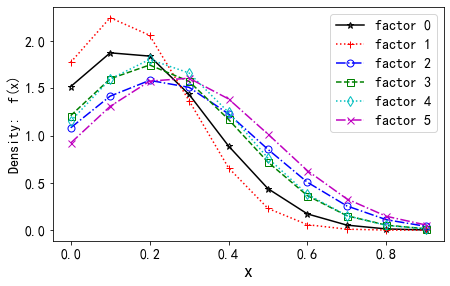

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches
dir_data = '../data/' # home win10

def normfun(x, mu, sigma):    
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf

def list_normalize(list): 
    return (list-min(list))/(max(list)-min(list))

file = "likelihood.csv"
data= pd.read_csv(dir_data+ file)
data= data[data["feature num"]== "10"] # select EMA+ feature
cols=['aug_factor','u00','u07','u10','u17','u34','u35','u47'] # when random seed =0
data =data.loc[:,cols]
data=data.astype(float) #consider the original data maybe in string formate, transform it to float format
data["aug_factor"]=data["aug_factor"].astype(int)
#  line style and color: https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html


marker_list =[ '*','+', 'o',  's', 'd', 'x', '^', 'v', '<', '>','.','p', 'h']
linestyle_list=['-',':','-.','--',':','-.','--',':','-.','--',':','-.']
color_list=['k','r','b','g','c','m','y','k','c','g']

plt.figure(figsize=(7,4.3))
factor_max = 5
for i in range(factor_max+1):
    d = data[data["aug_factor"]== i].iloc[:,1:]  # densities of all 12 AI models (shape of 12*7), column of "1:" means take out the factor number, if in str, transfer i to str
    result = list_normalize(d.to_numpy().flatten()) # with normalization all posibilities of 12 AI models, 84
#     result =d.to_numpy().flatten() # without normalization
    x = np.arange(min(result), max(result), 0.1) #change granularity by change 0.1 to 0.01
    y = normfun(x, result.mean(), result.std())
    plt.plot(x,y, 'k-', linestyle= linestyle_list[i], color= color_list[i],marker=marker_list[i], \
             mfc="None", label="factor "+str(i), markersize = 7)  # for color
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yticks([])


### for scalling y-axis to 100%
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'

# plt.xlabel('ratio of days on which a participant is classified as depressed',fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('Density:  f(x)', fontsize=14)
plt.legend(fontsize=14, loc='upper right')
plt.savefig(dir_data+'density_aug_color.pdf',format='pdf')
plt.show()

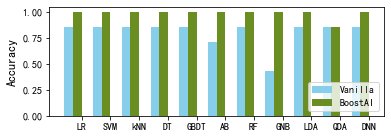

In [105]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

filename='../data/studentlife_result_byMetricsModelFactor_EMAplusSENSING.csv'
data = pd.read_csv(filename)


acc_data = data.where(data['metrics']=='A').dropna()

list_vanilla = acc_data.where(acc_data['factor']=='vanilla')[['value', 'model']].dropna()
list_fct1 = acc_data.where(acc_data['factor']=='1')[['value', 'model']].dropna()
list_fct1
models= model_order = ['LR','SVM','kNN','DT','GBDT','AB','RF','GNB','LDA','QDA','DNN']

l_fct1=list_fct1['value'].tolist()[:-1]
l_vanilla = list_vanilla['value'].tolist()
l_len = len(l_fct1)

plt.show()
plt.figure(figsize =(6,2))
bar_width = 0.3
position_vanilla = np.arange(l_len)
position_fct1 = np.arange(l_len)+bar_width
plt.bar(position_vanilla, height = l_vanilla, width=bar_width, color = 'skyblue', label = 'Vanilla')
plt.bar(position_fct1, height =l_fct1, width= bar_width, color ='olivedrab', label = 'BoostAI')

plt.legend(loc= 4) #upper left
plt.xticks(position_fct1+bar_width/2, models)
plt.ylabel('Accuracy', fontsize= 12)
# plt.title ('Accuracy comparison', fontsize=12)

dir_data = '../data/' 
plt.savefig(dir_data+'acc_comp.pdf',format='pdf')
